In [1]:
#%% Loading packages
import pandas as pd
print("pandas version: {}".format(pd.__version__))
import matplotlib
print("matplotlib version: {}".format(matplotlib.__version__))
import numpy as np
print("NumPy version: {}".format(np.__version__))
import scipy as sp
print("SciPy version: {}".format(sp.__version__))
import IPython
print("IPython version: {}".format(IPython.__version__))
import sklearn
print("scikit-learn version: {}".format(sklearn.__version__))

pandas version: 0.25.3
matplotlib version: 3.1.1
NumPy version: 1.17.4
SciPy version: 1.3.2
IPython version: 7.10.1
scikit-learn version: 0.21.3


In [2]:
#%% excel file containing data
filename = '/Users/mattw/OneDrive - Emory University/machine_learning/data/MIPS_JAN.xlsx'

In [3]:
import datetime
from dateutil.relativedelta import relativedelta

df = pd.read_excel(filename, sheet_name = 1)
rows,cols = df.shape

In [4]:
#%% Calculating Age
age=[]
for x,y in zip(df['dob'],df['enrollmentdate']):
    xs = x.split('-')
    ys = y.split('-')
    datex = datetime.datetime(int(xs[0]),int(xs[1]),int(xs[2])) # dob
    datey = datetime.datetime(int(ys[0]),int(ys[1]),int(ys[2])) # enrollment date
    age.append(relativedelta(datey,datex).years)
df['age'] = age

In [5]:
#%% gather target names
feature_names = ['age','gender', 'hispanic', 'asian', 'nativeamerican',
                 'africanamerican', 'pacificislander', 'caucasian',
                 'schoolyears', 'hypertension', 'diabetes', 'smokehistory',
                 'bmi', 'prefmd','bdi_sum','rest_systolic10minrest',
                 'rest_diastolic10minrest','rest_heartrate10minrest',
                 'restscan_diastolicvolume','restscan_systolicvolume',
                 'restscan_ejectfraction', 'il6_baseline', 'mcp1_baseline', 
                 'mmp_9_baseline', 'sdf_baseline', 'vegf_baseline', 'crp_baseline',
                 'icam1_baseline', 'vcam1_baseline']
target_names = ['prefmd']

In [6]:
#%% New DataFrame with limited columns and fixing data types
data = df.loc[:,feature_names]
data['smokehistory'] = data['smokehistory'].astype('category')
data['hispanic'] = data['hispanic'].astype('category')
data['asian'] = data['asian'].astype('category')
data['nativeamerican'] = data['nativeamerican'].astype('category')
data['africanamerican'] = data['africanamerican'].astype('category')
data['caucasian'] = data['caucasian'].astype('category')
data['pacificislander'] = data['pacificislander'].astype('category')
data['hypertension'] = data['hypertension'].astype('category')
data['diabetes'] = data['diabetes'].astype('category')
data['gender'] = data['gender'].astype('category')

In [12]:
#%% Doing One Hot Encoding on Smokehistory
data_ohe = pd.get_dummies(data)
print("Features after get_dummies:\n", list(data_ohe.columns))

Features after get_dummies:
 ['age', 'schoolyears', 'bmi', 'prefmd', 'bdi_sum', 'rest_systolic10minrest', 'rest_diastolic10minrest', 'rest_heartrate10minrest', 'restscan_diastolicvolume', 'restscan_systolicvolume', 'restscan_ejectfraction', 'il6_baseline', 'mcp1_baseline', 'mmp_9_baseline', 'sdf_baseline', 'vegf_baseline', 'crp_baseline', 'icam1_baseline', 'vcam1_baseline', 'gender_1', 'gender_2', 'hispanic_0', 'hispanic_1', 'asian_0', 'asian_1', 'nativeamerican_0', 'nativeamerican_1', 'africanamerican_0', 'africanamerican_1', 'pacificislander_0', 'pacificislander_1', 'caucasian_0', 'caucasian_1', 'hypertension_0', 'hypertension_1', 'diabetes_0', 'diabetes_1', 'smokehistory_1', 'smokehistory_2', 'smokehistory_3']


In [13]:
#%% Imputation - Is neded?
# Continuous Variables
continuous_var = ['age', 'schoolyears', 'bmi','bdi_sum','rest_systolic10minrest',
                 'rest_diastolic10minrest','rest_heartrate10minrest',
                 'restscan_diastolicvolume','restscan_systolicvolume',
                 'restscan_ejectfraction', 'il6_baseline', 'mcp1_baseline', 
                 'mmp_9_baseline', 'sdf_baseline', 'vegf_baseline', 'crp_baseline',
                 'icam1_baseline', 'vcam1_baseline','prefmd']

# Initial checks- NaN's and Zeros
test = data_ohe.loc[:,continuous_var] == 0
test = test[test[:] == True]

# Setting Up Imputer
from sklearn.impute import SimpleImputer

# Since our missing values are all 0's, replacing with mean
imp = SimpleImputer(missing_values = 0, strategy="mean")

for var in range(len(continuous_var)):
    n = continuous_var[var]
    data_ohe[[n]] = imp.fit_transform(data_ohe[[n]]).ravel() # Need ravel for dimensions

# Checking again for 0's - should return a 0 x 3 Dataframe 
test2 = data_ohe.loc[:,continuous_var] == 0
test2 = test2[test2[:] == True]

In [14]:
#%% Log Normalizing & imputing nan with mean
data_ohe['prefmd'] = np.log(data_ohe['prefmd'])
data_ohe['prefmd'] = data_ohe['prefmd'].fillna(np.nanmean(data_ohe['prefmd']))

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [15]:
#%% create the dataset dictionary
dataset = {}
dataset['target'] = data_ohe.pop(target_names[0])
dataset['data'] = data_ohe.values
dataset['target_names'] = target_names[0]
dataset['DESCR'] = 'n/a'
dataset['feature_names'] = data_ohe.columns
dataset['filename'] = filename

# split data for scikit-learn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset['data'], dataset['target'], random_state=0)

In [22]:
#%% KNN Regression
from sklearn.neighbors import KNeighborsRegressor
reg = KNeighborsRegressor(n_neighbors=8)
reg.fit(X_train, y_train)
print("Test set accuracy: {:.2f}".format(reg.score(X_test, y_test)))
knn_predictions = reg.predict(X_test)

Test set accuracy: -0.23


In [17]:
#%% Linear Regression    
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset['data'], dataset['target'], random_state=0)
lr = LinearRegression().fit(X_train, y_train)
print("Test set accuracy: {:.2f}".format(lr.score(X_test, y_test)))

lr_predictions = lr.predict(X_test)

Test set accuracy: 0.16


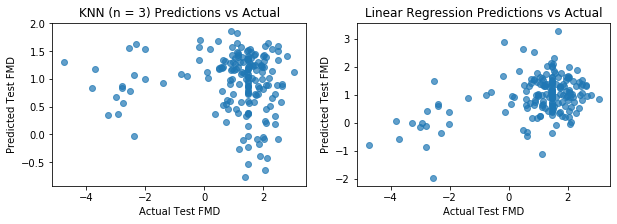

In [18]:
#%% Mutiplotting
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,2, figsize=(10,3))

plt.subplot(1,2,1)
plt.scatter(y_test, knn_predictions, alpha = 0.7)
plt.title('KNN (n = 3) Predictions vs Actual')
plt.xlabel('Actual Test FMD')
plt.ylabel('Predicted Test FMD')

plt.subplot(1,2,2)
plt.scatter(y_test, lr_predictions, alpha = 0.7)
plt.title('Linear Regression Predictions vs Actual')
plt.xlabel('Actual Test FMD')
plt.ylabel('Predicted Test FMD')

plt.show()

Test set accuracy: 0.34


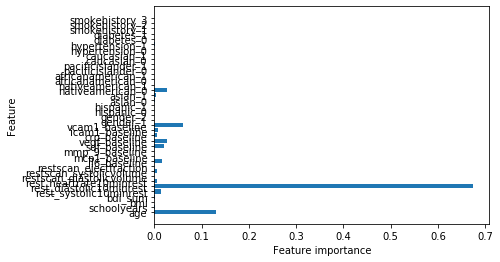

In [23]:
#%% Decision Tree
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor(max_depth=5).fit(X_train, y_train)
print("Test set accuracy: {:.2f}".format(tree.score(X_test, y_test)))

tree_pred = tree.predict(X_test)
#plt.scatter(y_test, tree_pred, alpha = 0.7)
#plt.title('Decision Tree Regression Predictions vs Actual')
#plt.xlabel('Actual Test FMD')
#plt.ylabel('Predicted Test FMD')

def plot_feature_importances_cancer(model):
    n_features = dataset['data'].shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), dataset['feature_names']) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances_cancer(tree)

Accuracy on training set: 0.935
Test set accuracy: 0.63


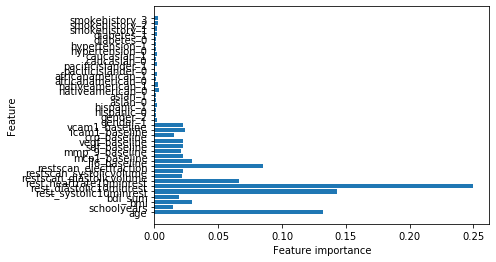

In [24]:
#%% Random Forest
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=100)
forest.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Test set accuracy: {:.2f}".format(forest.score(X_test, y_test)))
plot_feature_importances_cancer(forest)

random_pred = forest.predict(X_test)

Accuracy on training set: 0.869
Accuracy on test set: 0.635


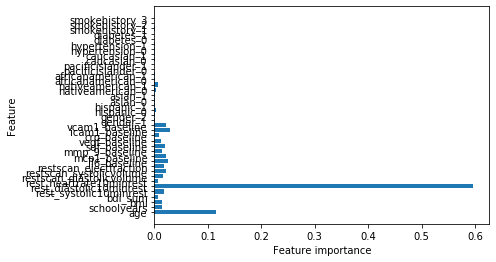

In [25]:
#%% Gradient Boosted Regression
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(random_state=0, learning_rate=0.05, max_depth=4)
gbrt.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

plot_feature_importances_cancer(gbrt)

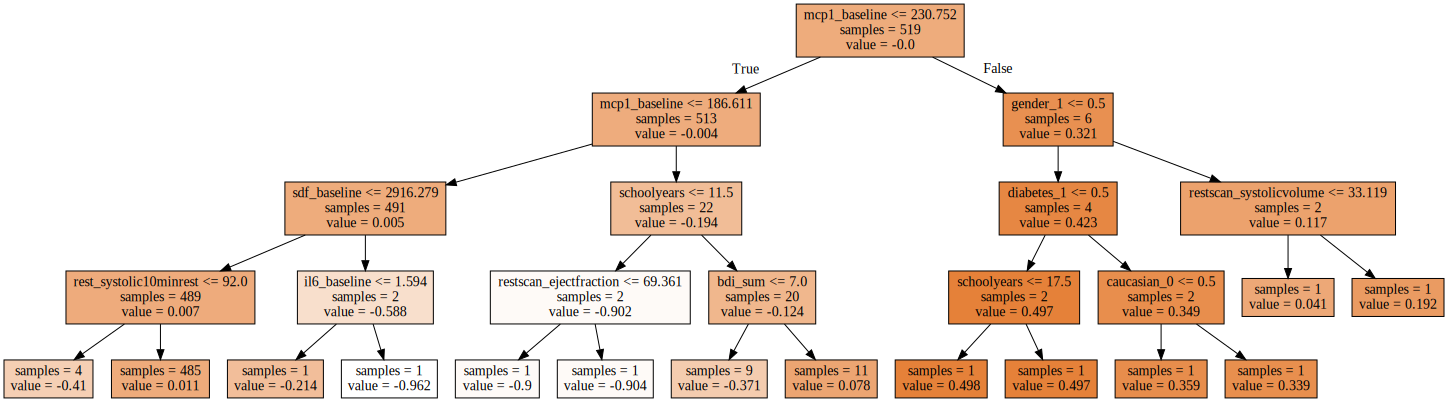

In [26]:
#%% GraphViz
import graphviz
from sklearn.tree import export_graphviz

export_graphviz(gbrt.estimators_[99,0], out_file = "tree.dot", feature_names=dataset['feature_names'], 
               impurity=False, filled=True)

with open("tree.dot") as f: 
    dot_graph = f.read()

graphviz.Source(dot_graph)